# Implementación de una Red Neuronal Casera

Vamos a implementar la red neuronal que se muestra en la figura a continuación

<img src="fig5.1.png" alt="Alternative text" width="400"/>
Cómo puede verse en la figura la red neuronal es una función que mapea una entrada que posee D componentes* a una salida que posee K componentes cuya parametrización resembla a la manera en la que se comportan las neuronas en nuestro cerebro. La función que mapea la entrada a la K-ésima componente de salida es
$$ \begin{align}
y_k(\mathbf{x}, \mathbf{w})&=f(a_k)=f\left( \sum_{j=1}^M w_{k j}^{(2)} h\left(a_j \right)+w_{k 0}^{(2)}\right)\\
&=f\left( \sum_{j=1}^M w_{k j}^{(2)} h\left( \sum_{i=1}^D w_{j i}^{(1)} x_i+w_{j 0}^{(1)}\right)+w_{k 0}^{(2)}\right) 
\end{align}
$$

Esta red neuronal tiene la particularidad de que posee sólo una capa oculta (hidden layer). 
Esta red la vamos a poder usar tanto para regresión como para clasificación. 

Para el problema de regresión vamos a ocupar cómo función de pérdida el error cuadrático medio (MSE), si llamamos $t_i$ al valor del dataset, el MSE es
$$E_{MSE} = \frac{1}{2N} \sum_{i=1}^{N} (t_i - y_i)^2$$

Las expresiones más importantes del algoritmo de *Backpropagation* son:

\begin{align}
\frac{\partial E}{\partial a_k} & = \frac{\partial E}{\partial y_k} \frac{\partial y_k}{\partial a_k} = \frac{\partial E}{\partial y_k} f'(a_k) \\
%
\frac{\partial E}{\partial a_j} & = \sum_k \frac{\partial E}{\partial a_k} \frac{\partial a_k}{\partial a_j} = \sum_k \frac{\partial E}{\partial a_k} w_{kj}h'(a_j) \\
%
\frac{\partial E}{\partial w_{ji}} & = \frac{\partial E}{\partial a_j} \frac{\partial a_j}{\partial w_{ji}} = \frac{\partial E}{\partial a_j} x_i\\
\end{align}



In [1]:
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import seaborn as sns
import matplotlib.pyplot as plt

def train_plot(loss_train,loss_val):   # Plot loss function and prediction
    fig=plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 14})
    p1=fig.add_subplot(1,1,1)
    p1.plot(loss_train, 'r',label='Train')
    p1.plot(loss_val, 'g',label='Validation')
    p1.set_yscale('log')
    p1.set_xscale('log')
    p1.grid('True', color='y')
    p1.set_xlabel("Epochs/Iterations")
    p1.set_ylabel("Loss")
    plt.legend();
    fig.tight_layout()

### Funciones de activación

In [2]:
def h(x,act='relu'): 
    """Funcion de activación para la hidden layer"""
    
    if act=='relu':    # Rectified linear unit (ReLU): máximo entre 0 y x
        return max(0.0,x)
    if act=='linear':
        ### ------------------------- HACER
        pass

def dh(x,act='relu'):
    """Derivada de la funcion de activación h"""
    
    if act=='relu':    # Derivada de la función ReLU
        if x<=0: return 0
        else:    return 1    
    if act=='linear':
        ### ------------------------- HACER
        pass
    
def f(x,act='linear'):
    """ Activación para la capa de salida  """
    if act=='linear':
        return x
    if act=='sig':
        ### ------------------------- HACER
        pass
        
def df(x,act='linear'):
    """ Derivada de la activación para la capa de salida  """
    if act=='linear':
        return 1
    if act=='sig':
        ### ------------------------- HACER
        pass
    
# vectorizamos las funciones y sus derivadas
h = np.vectorize(h); dh = np.vectorize(dh)
f = np.vectorize(f); df = np.vectorize(df)

if 0:
    x=np.arange(-1,1,0.01);
    [plt.plot(x,y) for y in [h(x),dh(x),f(x),df(x)]]    

In [3]:
class neuralnetwork():
    """ Clase de Neural Network
       -train: toma UN dato y ajusta los weights de la red neuronal usando backpropagation.
       -predict: hace la predicción del label para un caso en particular en base a las covariates.
       -train_nn: entrena una red neuronal sobre TODOS los datos del dataset durante un número especificado de épocas.
       -test_nn: evalua la red neuronal en los puntos del test set.
       -dataset: permite ingresar un dado dataset.
       -parameters: permite ingresar hiperparámetros."""
    
    def __init__(self):
        # D dimesión de los datos de entrada (que deben incluir el 1 para la intercept)
        # M número de hidden units 
        # K dimensión del espacio de salida
        # N número de datos en el dataset
        self.D=2; self.M=3; self.K=2; self.N=2
        self.wMD = np.random.rand(self.M,self.D+1)
        self.wKM = np.random.rand(self.K,self.M)
        self.lr = 0.001
        self.epochs = 10
        self.training_points = [((1,0.1,-0.3), (1,-1)),((1,0.2,+0.3), (1,1))]
        self.testing_points = [((1,0.1,-0.3), (1,-1)),((1,0.2,+0.3), (1,1))]
        
        
    def dataset(self, train=0, test=0):
        if type(train)!=int:
            np.random.seed(40)
            self.training_points = train
            self.D = len(train[0][0 ])
            self.K = len(train[0][-1])
            self.N = len(train)
            self.wMD = np.random.rand(self.M,self.D)
            self.wKM = np.random.rand(self.K,self.M)
            
        if type(test)!=int:
            self.testing_points = test        
        
    def parameters(self,M=2,lr=0.01,epochs=20):
        self.M  = M
        self.lr = lr
        self.epochs = epochs
    
    def train(self, x, t):
        ### forward propagation 
        #                                        Dimension
        inputs = x                                #(__,__)
        # activaciones de la hidden layer: aj=sum_i wji xi
        hidden_in  = self.wMD @ inputs            #(__,__)
        # output de la hidden layer:       zj=h(aj)
        hidden_out = h(hidden_in)     
        # activaciones de la output layer: ak=sum_k wkj zj
        output_in = self.wKM @ hidden_out         #(__,__)
        # predicción:                      yk=f(ak)
        output_out= f(output_in)   

        ### backpropagation 
        #
        # Derivada de E respecto ak               #(__,__)
        output_error = np.multiply( (output_out-t)/self.N,
                                    df(output_in)  ) 

        # Derivada de E respecto aj               #(__,__)
        hidden_error = np.multiply( dh(hidden_in),
                                   np.transpose(self.wKM)@output_error) 

        dwMD = np.outer(hidden_error,inputs)      #(__,__)
        dwKM = np.outer(output_error,hidden_out)  #(__,__)

        # Descenso de gradientes para ajustar los pesos y los bias
        self.wMD += -self.lr*dwMD 
        self.wKM += -self.lr*dwKM
        
    def predict(self, x):
        inputs = x                               
        hidden_in  = self.wMD @ inputs           
        hidden_out = h(hidden_in)     
        output_in = self.wKM @ hidden_out         
        output_out= f(output_in)

        return output_out

    def train_nn(self): #       Online training         
        mse_train=[];mse_test=[];
        for epoch in range(self.epochs):
            for x,y in self.training_points:
                self.train(x, y)

            #-----------------------                     HACER 
            
        #---------------------------                     HACER 
        
    def train_minibatch_nn(self): #                      HACER
        pass

    def test_nn(self,online=0):
        tiyi=[]; n_dispersos=0
        if online: print('(t_i, y_i)')
        for data in self.testing_points:
            ti, yi = data[1][0], self.predict(data[0])[0]
            tiyi.append([ti,yi])
            if abs(self.predict(data[0]) - data[1]) < 1.0:
                stat='bien'
            else:
                n_dispersos+=1
                stat='mal'
            if online:
                print(ti, np.round(yi,2),stat )
                
        print('El porcentaje de dipersos es',np.round( 100*n_dispersos/len(self.testing_points),3),'%')
        return np.array(tiyi)                

### <font color='red'> Tarea 1: El algoritmo de Backpropagation</font>
(a) Completar los espacios blancos dejados en el código, de la forma  #$(__,__)$, con la dimensión de los vectores y las matricies correspondientes.

(b) La expresión *general* que liga inputs, outputs y los parámetros de la NN, $y_k=f(\mathbf{x};\mathbf{w})$, está escrita al comienzo. Escriba la función *particular* correspondiente a como la red neuronal está implementada en la funcion 'neuralnetwork()'.

(c) *Funciones de activación:* vamos a implementar en los lugares señalados con '###---HACER' dos funciones de activación y sus derivadas, una función lineal para la capa oculta [útil para la regresión lineal] y una sigmoide [útil para el problema de clasificación].

(d) En la función 'train_nn' vamos a implementar la función de pérdida MSE y vamos a calcular el historico del MSE en cada época para los datos entrenamiento y de test.

(e) Implemente la función 'train_minibatch_nn' que ajusta los pesos promediando los gradientes del conjunto de puntos del batch. Para entrenar la red con esta función deberá preparar los datos de manera diferente a la implementada para entrenar con la rutina 'train_nn'. 

# Regresión
Sobre un dataset de interés histórico vamos a estudiar el efecto de los hiperparámetros de la red, el proceso de entrenamiento, ajuste de los coeficientes por el descenso del gradiente, el entrenamiento en 'batches', el rol de los 'epochs', el overfitting, entre otras cosas.

### Dataset: Altura de los hijos en función de la altura de los padres
El dataset consiste en alturas de padres e hijos [Galton (1886)] y la idea es entrenar la red neuronal para hacer la predicción de la altura de los hijos en función de la altura de los padres.  Tenemos los datos de 928 hijos adultos nacidos de 205 padres y madres. Los intervalos de clase de los datos soon de ancho 1.0 in, es decir 2.54cm. Estos datos. La muestra de Galton tenía alturas similares a las de los adultos contemporáneos (la altura promedio de mujeres y hombres adultos en el Reino Unido en 2010 fue de 63 y 69 pulgadas respectivamente).

In [4]:
GFdf = pd.read_csv('GFdf_father_mother_child.csv')
GFdf = GFdf.sample(frac=1, random_state=42)         # Mezclamos los datos
GFdf.head()
if 0: g =sns.scatterplot(data=GFdf.drop('father',axis=1),x='mother',y='childHeight');
GFdf.describe()

,father,mother,childHeight
count,934.000000,934.000000,934.000000
mean,69.197109,64.089293,66.745931
std,2.476479,2.290886,3.579251
min,62.000000,58.000000,56.000000
25%,68.000000,63.000000,64.000000
50%,69.000000,64.000000,66.500000
75%,71.000000,65.875000,69.700000
max,78.500000,70.500000,79.000000


In [5]:
# Separamos el dataset en dos grupos, uno para el entrenamiento de la nn y el otro para el test
GF_dataset=[]
for i in range(len(GFdf)):
    GF_dataset.append ( [[1,GFdf['father'][i],GFdf['mother'][i]], [ GFdf['childHeight'][i] ]] )
GF_dataset = np.array(GF_dataset,dtype=object); 

alpha=1.0 # porcentaje del data set

N=int(alpha*len(GF_dataset))
GF_train, GF_val = GF_dataset[:int(4/5*N)], GF_dataset[int(4/5*N):N]
print('len(Train)=',len(GF_train),'len(Validation)=',len(GF_val))

len(Train)= 747 len(Validation)= 187


### <font color='red'> Tarea 2: Entrenamiento de prueba </font>
A continuación vamos a entrenar sobre un dataset sencillo nuestra red casera y una red armada con los modulos de Pytorch. 

(a) Defina la NN1 como una instancia de la 'neuralnetwork()' con M=5,lr=0.02,epochs=400, alpha=1, entrene la NN1 y dibuje el mse. Imprima el vector de predicción y de targets. Entrene ahora con alpha=0.1 (el 10% de los datos) y ajuste el lr para obtener los mejores resultados.

(b) Calcule la cantidad de parámetros a entrenar.

(c) Ajuste la arquitectura de la red diseñada con pytorch opción 1 a la arquitectura de nuestra red casera. Tome un par de hiperparámetros, por ejemplo M=30, lr=1e-4 y compare los resultados de ambas redes, explique las diferencias.

# Nuestra NN





In [17]:
# Definimos nuestra red neuronal N°1
# HACER
if 0:
    print('Predicción (sin entrenar)')
    xi,ti=GF_train[2]
    print('Train      ',ti,NN1.predict(xi))
    xi,ti=GF_val[2]
    print('Validation ',ti,NN1.predict(xi))

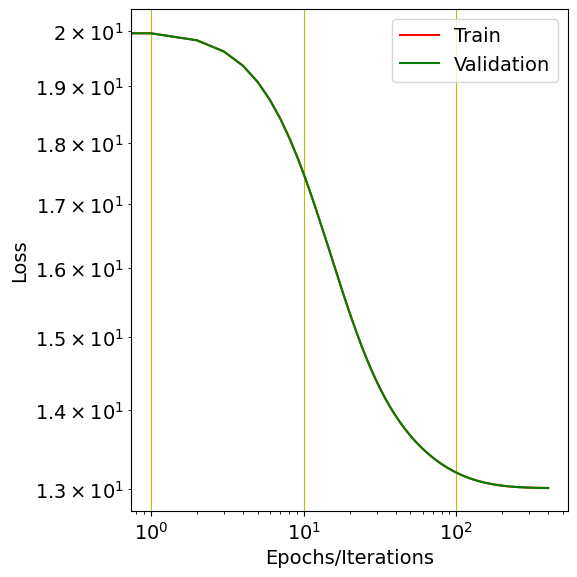

In [7]:
# HACER
train_plot(Jtrain,Jval)

In [16]:
print('Predicción')
xi,ti=GF_train[10]
print('Train      ',ti,NN1.predict(xi))
xi,ti=GF_val[10]
print('Validation ',ti,NN1.predict(xi))

Predicción


ValueError: too many values to unpack (expected 2)

# Pytorch






In [9]:
# Separamos el dataset en dos grupos, uno para el entrenamiento de la nn y el otro para el test
GF_dataset=GFdf.to_numpy(dtype=np.float32);  
N=int(alpha*len(GF_dataset))
GF_train, GF_test = GF_dataset[:int(4/5*N)], GF_dataset[int(4/5*N):N]

X_train=torch.tensor(GF_train[:,:2]); y_train=torch.tensor(GF_train[:,-1])
X_val  =torch.tensor(GF_test[:,:2]);  y_val =torch.tensor(GF_test[:,-1])
print('# len(Train)=',len(X_train),'# len(Validation)=',len(X_val))

# len(Train)= 747 # len(Validation)= 187


## Training con torch clases/funciones

Pasamos a la metodologia utilizada en pytorch, 
* se definen el optimizador (SGD=stochastic gradient descent) 
* la funcion de costo (MSE) 
* luego iniciamos las iteraciones, 
* Propagacion hacia adeltante:
    * realizando predicciones dado un set de parametros, 
    * evaluando la funcion de costo en la prediccion (propagacion hacia adelante)
*  Backprop:
    * se inicializan los gradientes a 0 (`zero_grad`) 
    * se hace la backward propagation desde la funcion de perdida hasta los parametros/inputs (`backward`).
* Por ultimo se actualizan los parametros con la info del gradiente en el optimizador (`step`).
* Diagnostico con  validation data

In [10]:
def train(model,n_epochs,n_epo_out=100):
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()
    losst=[]; lossv=[]
    for i in range(n_epochs):
        
        # Calculate predicted y from x
        y_pred = model(X_train)
    
        # Calculate loss
        loss = loss_fn(y_pred,y_train)
        if i%n_epo_out == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)
    
        losst.append(loss.item())

        # Backprop, first initialize with zero gradients
        optimizer.zero_grad()
        loss.backward()

        # Update parameters
        optimizer.step()
    
        with torch.no_grad(): # para validacion no se requiere de grad
            y_pred = model(X_val)
            loss = loss_fn(y_pred,y_val)
            lossv.append(loss.item())
            
    return losst, lossv

## Defino modelos en pytorch

Vamos a aprovechar los modelos predefinidos de pytorch para generar redes mas complejas. Dos estructuras utiles, la  `torch.nn.Linear `  que define la red lineal y `torch.nn.Sequential` que nos permite apilar estructuras. Entre las transformaciones lineales/capas ubicamos funciones de activacion e.g. `torch.nn.ReLU`

In [11]:
def set_model(opt,act_fn=torch.nn.ReLU):
    #act_fn=torch.nn.Tanh
    #act_fn=torch.nn.Sigmoid
    
    n_inputs = 2
    n_outputs = 1

    if opt == 0:        ##  Linear regression
        model = torch.nn.Linear(n_inputs, n_outputs)
    elif opt == 1:      ##  Genera una red de una hidden layer cómo la de la sección anterior
        n_hidden = 15
        model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                                    act_fn(), # relu activation function
                                    torch.nn.Linear(n_hidden, n_outputs))
        
    elif opt == 2:
        n_hidden = 100
        model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                                act_fn(), # relu activation function
                                torch.nn.Linear(n_hidden, n_hidden),
                                act_fn(), # relu activation function
                                torch.nn.Linear(n_hidden, n_outputs))

    return model

In [12]:
model=set_model(opt=1)
#summary(model,input_size=(len(X_train),2) )
Jtrain,Jval = train(model,400,100)
with torch.no_grad(): # no training
    y_pred_val2=model(X_val)

/home/dsac/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([747])) that is different to the input size (torch.Size([747, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dsac/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([187])) that is different to the input size (torch.Size([187, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:    0, loss: 4.84e+03
epoch:  100, loss: 5.37e+05
epoch:  200, loss: 9.46e+03
epoch:  300, loss: 1.79e+02


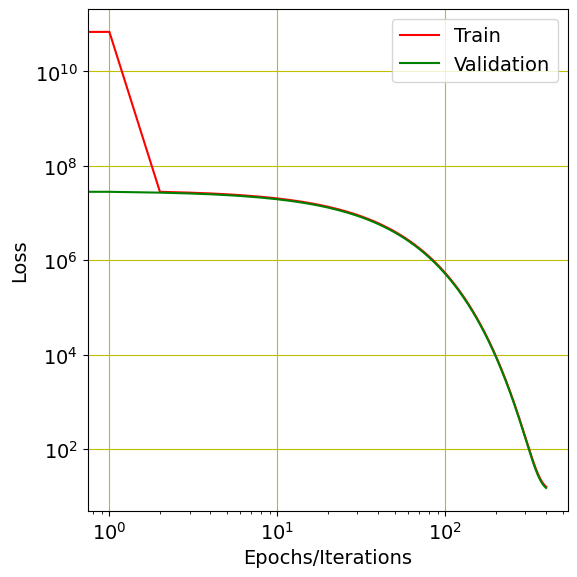

In [13]:
train_plot(Jtrain,Jval)

In [15]:
print('Predicción')
xi,ti=X_train[1],y_train[1]
print('Train',ti,model(xi).detach().numpy())
xi,ti=X_val[1],y_val[1]
print('Test ',ti,model(xi).detach().numpy())

Predicción
Train tensor(72.7000) [65.05828]
Test  tensor(66.) [65.05828]
